In [43]:
import os #os 모듈을 가져올 수 있다.
import random 
import numpy as np
import pandas as pd
from tqdm import tqdm #notebook 자동으로 진행상태를 시각적으로 보여주는 라이브러리
import torch
import torch.nn as nn #신경망을 생성하고 학습을 도움, 잘 디자인된 모듈과 클래스들을 제공
import torch.nn.functional as F 
from torch.utils.data import random_split 
     #데이터 세트를 분리하기 위해 torch.utils.data에서 random_split 함수를 포함시킵
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler 
     #트레이닝 및 테스트 데이터 지정
from torchvision import datasets, transforms, models #터치비전에서 데이터 가져오기
from torchvision.datasets import ImageFolder 
     #대용량 이미지 데이터를 데이터셋을 관리하기 편한 모듈
from torchvision.transforms import ToTensor #이미지를 텐서로 변환
from torchvision.utils import make_grid #그리드 만들기
from pytorch_lightning import LightningModule
     #lightning module은 trainer와 model이 상호작용할 수 있게 해주는 구현체
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt 
     #모듈의 각각의 함수를 사용해서 간편하게 그래프를 만들고 변화를 줄 수 있음
%matplotlib inline
from sklearn.model_selection import train_test_split #테스트, 검증 데이터 구분
from sklearn.metrics import classification_report 
     #sklearn.metrics에서 라이브러리 불러오기
from PIL import Image #이미지처리 라이브러리

In [44]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [45]:
dataset0=datasets.ImageFolder(root="./data/PokemonData/",transform=None)
        #지정된 경로로 데이터 불러오기
class_names=dataset0.classes
print(class_names) #데이터 클래스 이름 프린트
print(len(class_names))

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

In [46]:
class DataModule(pl.LightningDataModule): 
        #파이토치 라이트닝의 데이터모듈 클래스를 활용해서 트레이닝을 위한 데이터 준비와 구성
    
    def __init__(self, transform=transform, batch_size=32): 
        #배치 파라미터 설정(적정한 파라미터를 찾기 위해 여러번 진행함)
        super().__init__()
        self.root_dir = "./data/PokemonData/"
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data) #트에이닝 데이터와 테스트 데이터를 랜덤으로 8대2 비율로 적용
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset



In [37]:
#캐글예제

class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self): #아담을 옵티마이저로 씀
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [47]:
#예제 변경
#합성곱 레이어를 늘려서 좀 더 복잡한 패턴을 만든다.
#drop out레이어를 추가해서 전체 레이어 추가 후 오버피팅을 줄인다.
#합성곱 레이어 안의 필터 숫자를 높인다.
#
class BetterCNN(pl.LightningModule):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, len(class_names))
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = X.view(-1, 128 * 12 * 12)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [48]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = pl.Trainer(max_epochs=20)
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 168   
1 | conv2 | Conv2d | 880   
2 | fc1   | Linear | 5.6 M 
3 | fc2   | Linear | 10.2 K
4 | fc3   | Linear | 1.7 K 
5 | fc4   | Linear | 3.1 K 
---------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.460    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at /Users/seung/Desktop/AI/lightning_logs/version_7/checkpoints/epoch=19-step=3420.ckpt
Loaded model weights from the checkpoint at /Users/seung/Desktop/AI/lightning_logs/version_7/checkpoints/epoch=19-step=3420.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7214076519012451
        test_loss           1.1679595708847046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


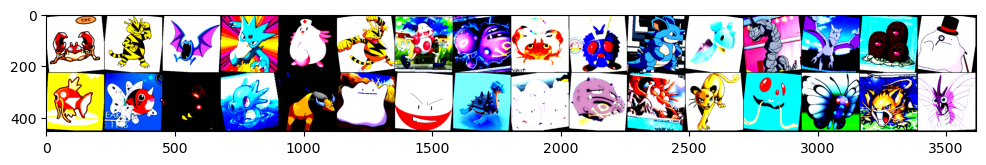

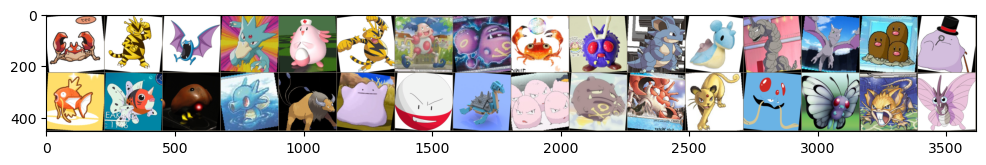

In [49]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [50]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                  precision    recall  f1-score   support

            Abra     0.6667    0.8000    0.7273        10
      Aerodactyl     0.5556    0.6250    0.5882         8
        Alakazam     1.0000    0.5000    0.6667         6
Alolan Sandslash     1.0000    0.8750    0.9333         8
           Arbok     0.7500    1.0000    0.8571         3
        Arcanine     1.0000    0.5714    0.7273         7
        Articuno     1.0000    0.7778    0.8750         9
        Beedrill     0.8571    1.0000    0.9231         6
      Bellsprout     1.0000    1.0000    1.0000         8
       Blastoise     0.7143    0.9091    0.8000        11
       Bulbasaur     1.0000    1.0000    1.0000         5
      Butterfree     1.0000    1.0000    1.0000         6
        Caterpie     0.7778    0.8750    0.8235         8
         Chansey     1.0000    0.8333    0.9091         6
       Charizard     0.4444    0.8000    0.5714         5
      Charmander     0.7778    0.7000    0.7368        10
      Charmel